# Stellar SV Fibre Assignment Analysis

Analyse the output of `ssv_fibers.ipynb`.

## Preamble

In [11]:
RUN_NAME = 'ssv_ref'

In [12]:
import os
import sys
import warnings
import subprocess
from   importlib import reload
import json
import glob

import astropy
import astropy.units as u
import astropy.coordinates as coord
from   astropy.io import fits
from   astropy.table import Table, Column

import numpy as np

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane

import fitsio

# Add the python scripts associated with this notebook (under ./py)
add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))


# Run an alternate DESItarget out of code directory
WITH_SSV_DESITARGET   = True
SSV_DESITARGET_PATH   = '/global/homes/a/apcooper/desi/code/desitarget/py/'
SSV_DESITARGET_BRANCH = 'stellar_sv'
if WITH_SSV_DESITARGET:
    add_sys_path.append(SSV_DESITARGET_PATH)

    ssv_desitarget_branch = subprocess.getoutput('pushd {} > /dev/null; git rev-parse --symbolic-full-name --abbrev-ref HEAD; popd > /dev/null'.format(SSV_DESITARGET_PATH))
    assert(ssv_desitarget_branch == SSV_DESITARGET_BRANCH)
    
for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.insert(0,_)

# This is the standard desitarget, we will swap it out later
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
    
import desitarget.io as io
import desitarget.mtl
import desitarget.cuts

import desitarget.sv1.sv1_cuts
import desitarget.sv1.sv1_targetmask
from   desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask, obsmask

from   desitarget.targetmask import obsconditions

# Local scripts for SSV        
import ssv
from   ssv.plan import Tile, Dither, DitherSet
import ssv.area as sv_area
import ssv.fiberqa
reload(sv_area)

# Import pyplot last
import matplotlib.pyplot as pl

MWS_TARGET_NAME    = 'MWS_TARGET'
BGS_TARGET_NAME    = 'BGS_TARGET'
DESI_TARGET_NAME   = 'DESI_TARGET'

DESITARGET_SURVEY  = 'SV1'
if DESITARGET_SURVEY.startswith('SV'):
    for _ in ['MWS_TARGET_NAME','BGS_TARGET_NAME','DESI_TARGET_NAME']:
        locals()[_] = '{}_{}'.format(DESITARGET_SURVEY,locals()[_])

# Setup directory environment
ROOT_DIR   = os.getcwd()
GLOBAL_DIR = os.path.join(ROOT_DIR,'global')
TILES_DIR  = os.path.join(GLOBAL_DIR,'tiles')
DATA_DIR   = os.path.join(ROOT_DIR,'data')
RUNS_DIR   = os.path.join(ROOT_DIR,'runs')

for d in ['ROOT_DIR','GLOBAL_DIR','TILES_DIR','DATA_DIR','RUNS_DIR']:
    print('{:10s} = {:s}'.format(d,locals()[d]))

ROOT_DIR   = /global/u1/a/apcooper/projects/ssv_plan
GLOBAL_DIR = /global/u1/a/apcooper/projects/ssv_plan/global
TILES_DIR  = /global/u1/a/apcooper/projects/ssv_plan/global/tiles
DATA_DIR   = /global/u1/a/apcooper/projects/ssv_plan/data
RUNS_DIR   = /global/u1/a/apcooper/projects/ssv_plan/runs


In [2]:
MTL_DIR = os.path.join(RUNS_DIR,RUN_NAME,'mtl')
OUT_DIR = os.path.join(RUNS_DIR,RUN_NAME,'out')

for _ in [MTL_DIR,OUT_DIR]:
    if not os.path.exists(_): os.makedirs(_)   

NameError: name 'RUN_NAME' is not defined

In [ ]:
############################################################
def match(arr1,arr2,arr2_sorted=False):
    """
    Update: Neither arr1 nor arr2 have to be sorted first. Only arr2 is sorted
    in operation, if it's already sorted, save time by setting
    arr2_sorted=True.

    For each element in arr1, return the index of the element with the same
    value in arr2, or -1 if there is no element with the same value.

    Algorithm may have originally been from John Helly.
    """
    from numpy import searchsorted, argsort, isscalar, arange, array, where
    
    tmp1 = arr1

    if arr2_sorted:
        # arr2 is already sorted
        idx  = slice(0,len(arr2))
        tmp2 = arr2
    else:
        idx  = argsort(arr2)
        tmp2 = arr2[idx]

    # Find where the elements of arr1 can be inserted in arr2
    ptr_l = searchsorted(tmp2,tmp1,side='left')
    ptr_r = searchsorted(tmp2,tmp1,side='right')

    if isscalar(ptr_l):
        ptr_l = array([ptr_l])
        ptr_r = array([ptr_r])

    # Return -1 where no match is found. Note that searchsorted returns
    # len(tmp2) for values beyond the maximum of tmp2. This cannot be used as an
    # index.
    # ind      = tmp2[ptr] != tmp1
    filter        = ptr_r-ptr_l == 0
    ptr_l[filter] = -1
    del(ptr_r,filter)

    # Put ptr back in original order
    ind   = arange(len(arr2))[idx]
    ptr_l = where(ptr_l >= 0, ind[ptr_l], -1)

    return ptr_l

## Read data on targets and tiles

In [ ]:
# Check the target bit definitions
for _ in mws_mask.names(): print(_)
mws_mask.names() == desitarget.sv1.sv1_targetmask.mws_mask.names()

In [ ]:
# Read raw targets
sweeps_json_path = os.path.join(TILES_DIR,'sweeps.json')
with open(sweeps_json_path,'r') as f:
    sweep_dict = json.load(f)

In [ ]:
# Read tile metadata
tiles_json_path = os.path.join(TILES_DIR,'all_mws_sv_tiles_names_to_ids.json')
with open(tiles_json_path,'r') as f:
    tile_meta = json.load(f)

In [ ]:
targetdata_path = os.path.join(DATA_DIR,'sv_targets-wscnd.fits')
targetdata      = fitsio.read(targetdata_path)

In [ ]:
print('{:,} targets'.format(len(targetdata)))

In [ ]:
# And the pure-secondary targets
scnd_targetdata_path = os.path.join(DATA_DIR,'secondary.fits')
scnd_targetdata      = fitsio.read(scnd_targetdata_path)

Sanity-check locations of targets relative to SV tiles. Targets should be in square patches (unions of bricks) around tile locations.

In [ ]:
tile_path = os.path.join(TILES_DIR,'all_mws_sv_tiles.fits')
tiles     = Table.read(tile_path)

In [3]:
tiles[0:3]

NameError: name 'tiles' is not defined

In [4]:
pl.scatter(targetdata['RA'][::100],targetdata['DEC'][::100])
pl.scatter(tiles['RA'],tiles['DEC'],c='r')

pl.axis('scaled')

NameError: name 'targetdata' is not defined

In [5]:
# Create a region for each tile and create a bitmask that identifies the targets in that region

In [6]:
import desimodel.footprint as footprint
from desitarget.targetmask import BitMask

In [7]:
targets_in_tiles = footprint.find_points_in_tiles(tiles,targetdata['RA'],targetdata['DEC'])

NameError: name 'tiles' is not defined

In [8]:
target_tilebits = np.zeros(len(targetdata),dtype=np.int64)
for itile in range(0,len(tiles)):
    target_tilebits[targets_in_tiles[itile]] |= int(2**(itile))

NameError: name 'targetdata' is not defined

In [9]:
bitlist  = [(i,i,"No comment") for i in range(0,64)]
tilemask = BitMask('SSV_TILES',{'SSV_TILES':bitlist})

In [10]:
targets_in_any_tile = target_tilebits > 0
print('{:,} targets in all SSV tiles'.format(targets_in_any_tile.sum()))

NameError: name 'target_tilebits' is not defined

In [21]:
targetdata_in_tiles = targetdata[target_tilebits > 0]

## Check unmatched secondary targets

These are objects that are not matched to PRIMARY targets. They might be matchable to sources in the LS, but if those sources are not targeted by a DESI survey, they will not be matched.

In [22]:
len(scnd_targetdata)

214

## Read MTL data

Rows should be more-or-less identical to the targetdata, but columns may differ.

In [23]:
# Compute MTL
mtl_path = os.path.join(MTL_DIR,'mtl.fits')
print('MTL path',mtl_path)
mtl = fitsio.read(mtl_path)
print('{:,} targets in MTL'.format(len(mtl)))

MTL path /global/u1/a/apcooper/projects/ssv_plan/runs/ssv_ref/mtl/mtl.fits
3,469,716 targets in MTL


In [24]:
mtl_in_tiles = footprint.find_points_in_tiles(tiles,mtl['RA'],mtl['DEC'])

In [25]:
mtl_tilebits = np.zeros(len(mtl),dtype=np.int64)
for itile in range(0,len(tiles)):
    mtl_tilebits[targets_in_tiles[itile]] |= int(2**(itile))
mtl_in_any_tile = mtl_tilebits > 0
print('{:,} MTL targets in all SSV tiles'.format(mtl_in_any_tile.sum()))

399,329 MTL targets in all SSV tiles


In [26]:
Table(mtl[0:2])

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,PRIORITY_INIT,SUBPRIORITY,NUMOBS_INIT,HPXPIXEL,SV1_SCND_TARGET,NUMOBS_MORE,PRIORITY,OBSCONDITIONS
int16,int32,bytes8,int32,bytes4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int32
8001,527901,2512p365,76,PSF,251.274418892,5.41859e+15,36.3956364365,3.98707e+15,2.03161e+06 .. 0.0,0.02123,69.4617,191.413,317.714,101.325,20.1412,8.46828,0.939089,0.95855,0.976599,4.32033e-06,3.57031e-07,3.34741e-06,0.0729566,0.134034,0.578977,0.999999,0.999999,0.999998,4,4,3,831.676,297.391,91.3948,635.825,185.39,47.7774,154.891,80.4818,-23.2873,-318.528,6.21966,1.19363,0.00151085,1.82876e-05,0.996409,0.997793,0.999529,0.999822,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.9255,148.6,246.652,53.9255,148.6,246.652,0,0,2066,1327385893669316480,G2,16.9321,1343.28,17.5883,105.963,16.1429,341.682,1.28184,0.0,False,0.147758,True,1.17272,266.626,3.48725,90.7746,-7.0272,44.845,N,35190984312619084,2305843009213693952,0,17,1100,0.771184098454,1,9431,0,1,1100,7
8001,527901,2512p365,77,PSF,251.268254272,2.37227e+14,36.3772873372,2.45609e+14,181043.0 .. 0.0,0.0209938,14.6331,23.4186,27.5195,311.651,83.5701,102.142,0.939746,0.959002,0.976856,1.62793e-05,6.42256e-06,2.56606e-05,0.00011451,0.250121,0.00706044,1.0,1.0,0.999999,4,4,4,831.676,210.016,182.005,635.825,132.625,93.0705,11.3786,2.88756,-16.7939,158.141,6.08589,1.18637,0.00152351,1.8687e-05,0.996449,0.997817,0.999534,0.999824,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.3474,18.1602,21.3403,11.3474,18.1602,21.3404,0,0,2050,1327385721870615680,G2,19.1937,329.668,19.6253,21.9855,18.582,44.7052,1.24102,0.617364,False,0.637567,True,0.219082,15.6313,-5.33403,3.62344,-1.73062,2.45733,N,35190984312619085,2305843009213693952,0,49152,1050,0.906783787488,1,9431,0,1,1050,7


In [27]:
Table(targetdata[0:2])

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,PRIORITY_INIT,SUBPRIORITY,NUMOBS_INIT,HPXPIXEL,SV1_SCND_TARGET
int16,int32,bytes8,int32,bytes4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,float64,int64,int64,int64
8001,527901,2512p365,76,PSF,251.274418892,5.41859e+15,36.3956364365,3.98707e+15,2.03161e+06 .. 0.0,0.02123,69.4617,191.413,317.714,101.325,20.1412,8.46828,0.939089,0.95855,0.976599,4.32033e-06,3.57031e-07,3.34741e-06,0.0729566,0.134034,0.578977,0.999999,0.999999,0.999998,4,4,3,831.676,297.391,91.3948,635.825,185.39,47.7774,154.891,80.4818,-23.2873,-318.528,6.21966,1.19363,0.00151085,1.82876e-05,0.996409,0.997793,0.999529,0.999822,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.9255,148.6,246.652,53.9255,148.6,246.652,0,0,2066,1327385893669316480,G2,16.9321,1343.28,17.5883,105.963,16.1429,341.682,1.28184,0.0,False,0.147758,31,1.17272,266.626,3.48725,90.7746,-7.0272,44.845,N,35190984312619084,2305843009213693952,0,17,1100,0.771184098454,1,9431,0
8001,527901,2512p365,77,PSF,251.268254272,2.37227e+14,36.3772873372,2.45609e+14,181043.0 .. 0.0,0.0209938,14.6331,23.4186,27.5195,311.651,83.5701,102.142,0.939746,0.959002,0.976856,1.62793e-05,6.42256e-06,2.56606e-05,0.00011451,0.250121,0.00706044,1.0,1.0,0.999999,4,4,4,831.676,210.016,182.005,635.825,132.625,93.0705,11.3786,2.88756,-16.7939,158.141,6.08589,1.18637,0.00152351,1.8687e-05,0.996449,0.997817,0.999534,0.999824,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.3474,18.1602,21.3403,11.3474,18.1602,21.3404,0,0,2050,1327385721870615680,G2,19.1937,329.668,19.6253,21.9855,18.582,44.7052,1.24102,0.617364,False,0.637567,31,0.219082,15.6313,-5.33403,3.62344,-1.73062,2.45733,N,35190984312619085,2305843009213693952,0,49152,1050,0.906783787488,1,9431,0


## Read fiberassign output

This is stored per tile. Both 'raw' and post-processed tables are available.

In [28]:
# Set these for main survey or SV
STANDARDS_PER_PETAL  = 20 # SV 20, MAIN 10
SKYS_PER_PETAL       = 80 # SV 80, MAIN 40

In [29]:
!ls $OUT_DIR

fiberassign_001000.fits  fiberassign_001018.fits  tile-001009.fits
fiberassign_001001.fits  fiberassign_001019.fits  tile-001010.fits
fiberassign_001002.fits  fiberassign_001020.fits  tile-001011.fits
fiberassign_001003.fits  fiberassign_001021.fits  tile-001012.fits
fiberassign_001004.fits  fiberassign_001022.fits  tile-001013.fits
fiberassign_001005.fits  fiberassign_001023.fits  tile-001014.fits
fiberassign_001006.fits  fiberassign_001028.fits  tile-001015.fits
fiberassign_001007.fits  fiberassign_001029.fits  tile-001016.fits
fiberassign_001008.fits  fiberassign_001030.fits  tile-001017.fits
fiberassign_001009.fits  tile-001000.fits	  tile-001018.fits
fiberassign_001010.fits  tile-001001.fits	  tile-001019.fits
fiberassign_001011.fits  tile-001002.fits	  tile-001020.fits
fiberassign_001012.fits  tile-001003.fits	  tile-001021.fits
fiberassign_001013.fits  tile-001004.fits	  tile-001022.fits
fiberassign_001014.fits  tile-001005.fits	  tile-001023.fits
fiberassign_001015.fits  tile-0

In [30]:
reload(ssv.fiberqa)

<module 'ssv.fiberqa' from '/global/u1/a/apcooper/projects/ssv_plan/py/ssv/fiberqa.py'>

In [31]:
fa_output = ssv.fiberqa.FiberAssignFiles(OUT_DIR)

Have 27 tiles


In [32]:
# Read the outputs of the fiberassign python script (post-processed/value-added 
# versions of raw output from fiberassign_exec). There are 3 extensions.
print('Fiber tile dir:',OUT_DIR)

fib = fa_output.load_fiber_data('FIBERASSIGN',simple=True)
pot = fa_output.load_fiber_data('POTENTIAL_ASSIGNMENTS',simple=True)
tgt = fa_output.load_fiber_data('TARGETS',simple=True)

Fiber tile dir: /global/u1/a/apcooper/projects/ssv_plan/runs/ssv_ref/out
Have 27 tiles
Have 27 tiles
Have 27 tiles


Flag MTL targets that were observed.

In [33]:
mtl_observed_tilebits = np.zeros(len(mtl),dtype=np.int64)
mtl_avail_tilebits    = np.zeros(len(mtl),dtype=np.int64)

for itile in range(0,len(tiles)):
    tileid = tiles['TILEID'][itile]
    
    if not tileid in fib.keys():
        print('Tile ID {} not in fiber tables'.format(tileid))
        continue
        
    # Observed
    observed_targets = fib[tileid]
    idx_mtl_observed_this_tile = match(observed_targets['TARGETID'],mtl['TARGETID'])
    # Not all targetids will be matched: skies
    m = idx_mtl_observed_this_tile >= 0
    mtl_observed_tilebits[idx_mtl_observed_this_tile[m]] |= int(2**(itile))
    
    # Available
    avail_targets = pot[tileid]
    idx_mtl_avail_this_tile = match(avail_targets['TARGETID'],mtl['TARGETID'])
    # Not all targetids will be matched: skies
    m = idx_mtl_avail_this_tile >= 0
    mtl_avail_tilebits[idx_mtl_avail_this_tile[m]] |= int(2**(itile))   
    
mtl_observed_any_tile = mtl_observed_tilebits > 0
print('{:,} MTL targets observed in all SSV tiles'.format(mtl_observed_any_tile.sum()))

mtl_avail_any_tile = mtl_avail_tilebits > 0
print('{:,} MTL targets available in all SSV tiles'.format(mtl_avail_any_tile.sum()))

Tile ID 1024 not in fiber tables
Tile ID 1025 not in fiber tables
Tile ID 1026 not in fiber tables
Tile ID 1027 not in fiber tables
110,667 MTL targets observed in all SSV tiles
332,840 MTL targets available in all SSV tiles


In [34]:
tile_to_program = dict([(_,k) for k,v in tile_meta.items() for _ in v ])

In [35]:
tile_to_program

{1000: 'NGP',
 1001: 'M53+N5053',
 1002: 'M53+N5053',
 1003: 'GD1-B',
 1004: 'GD1-B',
 1005: 'GD1-B',
 1006: 'M5',
 1007: 'M5',
 1008: 'M13',
 1009: 'M13',
 1010: 'DRACO',
 1011: 'DRACO',
 1012: 'DRACO',
 1013: 'DRACO',
 1014: 'M67',
 1015: 'M67',
 1016: 'M92',
 1017: 'M92',
 1018: 'M15',
 1019: 'M15',
 1020: 'LOWB',
 1021: 'LOWB',
 1022: 'BOSS7456',
 1023: 'GD1-C',
 1024: 'HYADES',
 1025: 'HYADES',
 1026: 'HYADES',
 1027: 'HYADES',
 1028: 'ORPHAN-A',
 1029: 'ORPHAN-A',
 1030: 'ORPHAN-A'}

For each tile, count the fraction of main survey targets observed. Targets can be observed on more than one tile. This is only completeness per tile, not completeness for a given area (which might be covered by multiple tiles).

In [36]:
for itile in range(0,len(tiles)):
    tileid = tiles['TILEID'][itile]
    
    if not tileid in fib.keys():
        print('Tile ID {} ({}) not in fiber tables'.format(tileid,tile_to_program[tileid]))
        continue
        
    is_mws_sv_main        = (mtl[MWS_TARGET_NAME] & mws_mask['MWS_MAIN_SV']) != 0
    is_observed_this_tile = (mtl_observed_tilebits & 2**itile) != 0
    is_in_this_tile       = (mtl_tilebits & 2**itile) != 0
    
    frac_observed = np.sum(is_mws_sv_main & is_observed_this_tile) / np.sum(is_mws_sv_main & is_in_this_tile)
    
    print("{:15s} {:4d} {:4.0f}%".format(tile_to_program[tileid], tileid, frac_observed*100))  

NGP             1000   54%
M53+N5053       1001   33%
M53+N5053       1002   24%
GD1-B           1003   51%
GD1-B           1004   49%
GD1-B           1005   49%
M5              1006   14%
M5              1007   14%
M13             1008   23%
M13             1009   23%
DRACO           1010   23%
DRACO           1011   22%
DRACO           1012   18%
DRACO           1013   15%
M67             1014   29%
M67             1015   26%
M92             1016   19%
M92             1017   19%
M15             1018    9%
M15             1019    9%
LOWB            1020   13%
LOWB            1021   13%
BOSS7456        1022   41%
GD1-C           1023   55%
Tile ID 1024 (HYADES) not in fiber tables
Tile ID 1025 (HYADES) not in fiber tables
Tile ID 1026 (HYADES) not in fiber tables
Tile ID 1027 (HYADES) not in fiber tables
ORPHAN-A        1028   48%
ORPHAN-A        1029   47%
ORPHAN-A        1030   48%


For each area, report the fraction of unique targets observed over all tiles (completeness per area)

In [37]:
tile_meta

{'NGP': [1000],
 'M53+N5053': [1001, 1002],
 'GD1-B': [1003, 1004, 1005],
 'M5': [1006, 1007],
 'M13': [1008, 1009],
 'DRACO': [1010, 1011, 1012, 1013],
 'M67': [1014, 1015],
 'M92': [1016, 1017],
 'M15': [1018, 1019],
 'LOWB': [1020, 1021],
 'BOSS7456': [1022],
 'GD1-C': [1023],
 'HYADES': [1024, 1025, 1026, 1027],
 'ORPHAN-A': [1028, 1029, 1030]}

In [38]:
def print_counts(d,bitmask=None,total=False):
    """
    Prints counts of unique values.
    """
    u = np.unique(d,return_counts=True)
    for _,c in zip(*u):
        if bitmask is not None:
            m = bitmask.names(_)
        else:
            m = ''
        print('{:20d} {:7d} {}'.format(_,c,m))
    
    if total:
        print('{:20s} {:7d}'.format('TOTAL',np.sum(u[1])))
    return

In [41]:
tile_meta

{'NGP': [1000],
 'M53+N5053': [1001, 1002],
 'GD1-B': [1003, 1004, 1005],
 'M5': [1006, 1007],
 'M13': [1008, 1009],
 'DRACO': [1010, 1011, 1012, 1013],
 'M67': [1014, 1015],
 'M92': [1016, 1017],
 'M15': [1018, 1019],
 'LOWB': [1020, 1021],
 'BOSS7456': [1022],
 'GD1-C': [1023],
 'HYADES': [1024, 1025, 1026, 1027],
 'ORPHAN-A': [1028, 1029, 1030]}

In [40]:
targetclasses = ['MWS_WD_SV','MWS_NEARBY_SV','MWS_MAIN_SV','MWS_MAIN_SV_FAINT']
for iclass,targetclass in enumerate(targetclasses):
    print('== {} =='.format(targetclass))
    for program in tile_meta.keys():
        is_observed_this_program = np.repeat(False,len(mtl))
        is_in_this_program       = np.repeat(False,len(mtl))
        is_in_all_this_program   = np.repeat(True, len(mtl))
        for tileid in tile_meta[program]:
            itile = np.flatnonzero(tiles['TILEID'] == tileid)[0]
            is_observed_this_program |= ((mtl_observed_tilebits & 2**itile) != 0)
            is_in_this_program       |= ((mtl_tilebits & 2**itile) != 0)         
            is_in_all_this_program   &= ((mtl_tilebits & 2**itile) != 0)         
        
        if not np.any(is_observed_this_program):
            print('No targets observed for area {}'.format(program))
            continue

        is_target  = (mtl[MWS_TARGET_NAME] & mws_mask[targetclass]) != 0
        
        # Eliminate overlaps with higher-ranked classes
        for higher_class in targetclasses[:iclass]:
            other_target = ((mtl[MWS_TARGET_NAME] & mws_mask[higher_class]) != 0)
            is_target   &= ~other_target
        
        frac_observed     = np.sum(is_target & is_observed_this_program) / np.sum(is_target & is_in_this_program)
        frac_observed_all = np.sum(is_target & is_observed_this_program & is_in_all_this_program) / np.sum(is_target & is_in_all_this_program)

        ntiles = len(tile_meta[program])
        print("{:15s} {:d} field{} {:4.0f}% {:4.0f}% {}".format(program, ntiles, 's,' if ntiles > 1 else ', ', 
                                                       frac_observed*100, 
                                                       frac_observed_all*100,
                                                       np.sum(is_target & is_observed_this_program)))  
    print()
    

== MWS_WD_SV ==
NGP             1 field,    96%   96% 26
M53+N5053       2 fields,   90%   90% 37


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in long_scalars


GD1-B           3 fields,   91%  nan% 96
M5              2 fields,   74%   74% 48
M13             2 fields,   87%   87% 40
DRACO           4 fields,   85%   85% 41
M67             2 fields,   87%   87% 41
M92             2 fields,   84%   84% 41
M15             2 fields,   57%   57% 61
LOWB            2 fields,   83%   83% 20
BOSS7456        1 field,    90%   90% 35
GD1-C           1 field,    82%   82% 23
No targets observed for area HYADES
ORPHAN-A        3 fields,   90%  nan% 82

== MWS_NEARBY_SV ==
NGP             1 field,    65%   65% 11
M53+N5053       2 fields,   84%   84% 21
GD1-B           3 fields,   97%  nan% 37
M5              2 fields,   57%   57% 12
M13             2 fields,   93%   93% 13
DRACO           4 fields,   87%   87% 13
M67             2 fields,   85%   85% 23
M92             2 fields,  100%  100% 15
M15             2 fields,   62%   62% 33
LOWB            2 fields,   88%   88% 21
BOSS7456        1 field,    89%   89% 17
GD1-C           1 field,    76%   76% 13


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in true_divide


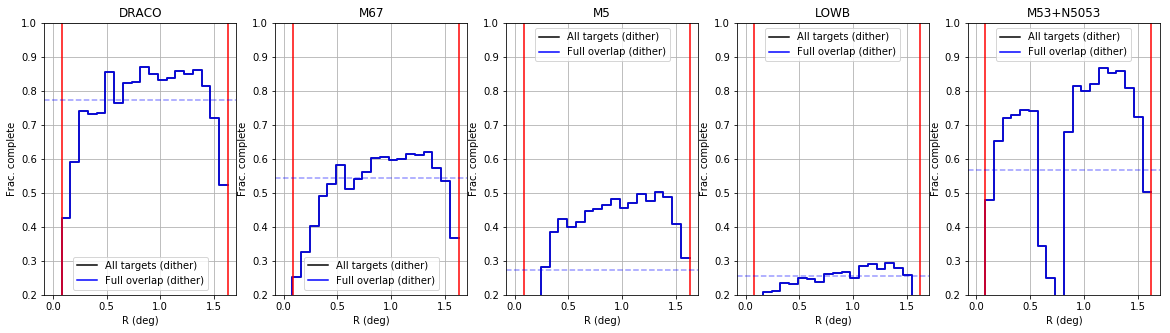

In [85]:
R_TILE = desimodel.focalplane.get_tile_radius_deg()

f = pl.figure(figsize=(20,5))

for iprog,program in enumerate(['DRACO','M67','M5','LOWB','M53+N5053']):
    f.add_subplot(1,5,iprog+1)
    area = sv_area.SSV_AREAS[program]
    ctr  = area['coord']
    
    targetclasses = ['MWS_MAIN_SV']
    for iclass,targetclass in enumerate(targetclasses):
        is_observed_this_program = np.repeat(False,len(mtl))
        is_in_this_program       = np.repeat(False,len(mtl))
        is_in_all_this_program   = np.repeat(True, len(mtl))
        for tileid in tile_meta[program]:
            itile = np.flatnonzero(tiles['TILEID'] == tileid)[0]
            is_observed_this_program |= ((mtl_observed_tilebits & 2**itile) != 0)
            is_in_this_program       |= ((mtl_tilebits & 2**itile) != 0)         
            is_in_all_this_program   &= ((mtl_tilebits & 2**itile) != 0)         

        if not np.any(is_observed_this_program):
            print('No targets observed for area {}'.format(program))
            continue

        is_target  = (mtl[MWS_TARGET_NAME] & mws_mask[targetclass]) != 0

        sep = np.repeat(np.inf,len(mtl))
        sep[is_in_this_program] = ctr.separation(coord.SkyCoord(mtl['RA'][is_in_this_program],
                                                                mtl['DEC'][is_in_this_program],
                                                                unit='deg',frame='icrs'))
        # Eliminate overlaps with higher-ranked classes
        for higher_class in targetclasses[:iclass]:
            other_target = ((mtl[MWS_TARGET_NAME] & mws_mask[higher_class]) != 0)
            is_target   &= ~other_target

        frac_observed     = np.sum(is_target & is_observed_this_program) / np.sum(is_target & is_in_this_program)
        frac_observed_all = np.sum(is_target & is_observed_this_program & is_in_all_this_program) / np.sum(is_target & is_in_all_this_program)

        bins       = np.arange(0.0,2.0,R_TILE/20.0)
        hsep_obs,_ = np.histogram(sep[is_target & is_observed_this_program],bins=bins)
        hsep_in, _ = np.histogram(sep[is_target & is_in_this_program],bins=bins)
        hsep_all,_ = np.histogram(sep[is_target & is_observed_this_program & is_in_all_this_program],bins=bins)

        pl.plot(bins[:-1],hsep_obs/np.array(hsep_in,dtype=np.float),drawstyle='steps-post',c='k',label='All targets (dither)')
        pl.plot(bins[:-1],hsep_all/np.array(hsep_in,dtype=np.float),drawstyle='steps-post',c='b',label='Full overlap (dither)')
        pl.axvline(desimodel.focalplane.get_tile_radius_deg(),c='r')
        pl.axvline(5.0/60.0,c='r')
        pl.axhline(frac_observed_all,c='b',ls='--',alpha=0.4)
        pl.ylim(0.2,1)
        pl.title(program.upper())

        nodither_file = 'no_dither_{}.npz'.format(program.lower())
        np.savez(nodither_file,hsep_obs,hsep_in,hsep_all)

        pl.legend()
        pl.grid()
        pl.xlabel('R (deg)')
        pl.ylabel('Frac. complete')
        
        

### Why such low completeness on MWS_MAIN_SV at the NGP?

Why are SV_FAINT targets being picked up when there are MAIN targets available?

In [411]:
NGP_TILE  = tile_meta['NGP'][0]
NGP_ITILE = np.flatnonzero(tiles['TILEID'] == NGP_TILE)[0]
NGP_FIB   = fib[NGP_TILE] # Tile of interest
NGP_POT   = pot[NGP_TILE]

In [412]:
is_avail_ngp  = np.repeat(False,len(mtl))
is_avail_ngp |= ((mtl_avail_tilebits & 2**NGP_ITILE) != 0)

In [413]:
STANDARDS_PER_PETAL*10

200

In [414]:
SKYS_PER_PETAL*10

800

In [415]:
print('Science fibers per tile:',5000-(STANDARDS_PER_PETAL+SKYS_PER_PETAL)*10)

Science fibers per tile: 4000


In [418]:
is_main_ngp = is_avail_ngp & ((mtl['SV1_MWS_TARGET'] & mws_mask['MWS_MAIN_SV']) !=0)
print(is_main_ngp.sum())

5048


In [419]:
# Maximum completeness given science fibers available
100.0*(4000.0/is_main_ngp.sum())

79.239302694136299

In [420]:
print_counts(NGP_FIB['FA_TYPE'])

                   1    3750 
                   2       1 
                   3     356 
                   4     892 
                   8       1 


Interpretation:
 - `FA_TYPE = 0` are spare fibers
 - `FA_TYPE = 1` have MWS_ANY only
 - `FA_TYPE = 2` have STD_* only
 - `FA_TYPE = 3` have both STD_* and MWS_ANY
 - `FA_TYPE = 4` are skies
 - `FA_TYPE = 8` are safe

In [114]:
print_counts(NGP_FIB['SV1_DESI_TARGET'][NGP_FIB['SV1_DESI_TARGET']>0],bitmask=desi_mask,total=True)

         34359738368      10 ['STD_BRIGHT']
         42949672960       1 ['STD_FAINT', 'STD_BRIGHT']
 2305843009213693952    3740 ['MWS_ANY']
 2305843017803628544     178 ['STD_FAINT', 'MWS_ANY']
 2305843026393563136      26 ['STD_WD', 'MWS_ANY']
 2305843052163366912     147 ['STD_FAINT', 'STD_BRIGHT', 'MWS_ANY']
TOTAL                   4102


In [113]:
print_counts(NGP_FIB['SV1_MWS_TARGET'][NGP_FIB['SV1_MWS_TARGET']>0],bitmask=mws_mask,total=True)

                   2       4 ['MWS_WD_SV']
                   4       4 ['MWS_NEARBY_SV']
                  33    3119 ['MWS_MAIN_SV', 'MWS_MAIN_SV_SOUTH']
                  35       7 ['MWS_MAIN_SV', 'MWS_WD_SV', 'MWS_MAIN_SV_SOUTH']
                  37       6 ['MWS_MAIN_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_SOUTH']
                  39       2 ['MWS_MAIN_SV', 'MWS_WD_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_SOUTH']
               81920     935 ['MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
               81922      11 ['MWS_WD_SV', 'MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
               81924       1 ['MWS_NEARBY_SV', 'MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
               81926       2 ['MWS_WD_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
TOTAL                   4091


In [117]:
# The difference between the totals are the standards that are not MWS targets
4102-4091

11

In [118]:
# But there is also a difference in the number of MWS targets
4091-3740

351

In [120]:
# Which is equal to the number of MWS targets that are also standards
178+147+26

351

In [121]:
# Question is why only 3119 MWS_MAIN_SV targets, when 935 MWS_MAIN_SV_FAINT?

In [241]:
# Select all fibers where this happens
# Star from list of fibers that are allocated to faint targets
# Restrict this to 'pure' SV_FAINT targets otherwise get cases e.g. blocking target is FAINT and WD
is_faint_ngp_fib = ((NGP_FIB['SV1_MWS_TARGET'] == (mws_mask['MWS_MAIN_SV_FAINT'] | mws_mask['MWS_MAIN_SV_FAINT_SOUTH'])) !=0)
is_faint_ngp_fib.sum()

935

In [242]:
# Check if any MAIN targets available to these fibers

In [243]:
mtl_blocked_on_faint = np.repeat(False,len(mtl))
blocked_targetids  = list()
blocking_targetids = list()

for ifib in np.flatnonzero(is_faint_ngp_fib):
    my_targetid = NGP_FIB['TARGETID'][ifib]
    other_pot   = (NGP_POT['FIBER'] == ifib) & (NGP_POT['TARGETID'] != my_targetid)
    assert(len(other_pot)>0)
    blocked_targetids.append(NGP_POT['TARGETID'][other_pot])
    blocking_targetids.append(my_targetid)
    
all_blocked_targetids  = np.concatenate(blocked_targetids)
all_blocking_targetids = np.array(blocking_targetids)

blocked_targetids = np.unique(all_blocked_targetids)

# Targetids are not blocked if they are assigned to other fibers
_ = np.in1d(blocked_targetids,NGP_FIB['TARGETID'])
blocked_targetids = blocked_targetids[~_]

# NOT IMPLEMENTED: Targetids are not blocked if they are in the potential list of a higher priority target that did get assigned
m = match(blocked_targetids,mtl['TARGETID'])
assert(np.all(m>=0))
mtl_blocked_on_faint[m] = True


In [258]:
print('{:d} extra targets blocked on {:d} MWS_MAIN_SV_FAINT fibers'.format(mtl_blocked_on_faint.sum(),is_faint_ngp_fib.sum()))
print()
print_counts(mtl['SV1_MWS_TARGET'][mtl_blocked_on_faint],bitmask=mws_mask,total=True)

447 extra targets blocked on 935 MWS_MAIN_SV_FAINT fibers

                   0      10 []
                  33      34 ['MWS_MAIN_SV', 'MWS_MAIN_SV_SOUTH']
               81920     403 ['MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
TOTAL                    447


What are those odd 10?

In [246]:
odd = mtl['SV1_MWS_TARGET'][mtl_blocked_on_faint] == 0
print_counts(mtl['SV1_DESI_TARGET'][mtl_blocked_on_faint][odd],bitmask=desi_mask)

         34359738368       7 ['STD_BRIGHT']
         42949672960       3 ['STD_FAINT', 'STD_BRIGHT']


They're un-used standards that are not MWS targets.

We're left with only 34 cases where a MAIN_SV_FAINT fiber could go to an unallocated MAIN_SV target. From the analysis below, using debugging options to `fba_run`, these look like regular collisions between selecting the higher-priority target and another fiber already on a high priority target.

In [247]:
# Blocked MAIN_SV targets
_  = np.flatnonzero((mtl['SV1_MWS_TARGET'][mtl_blocked_on_faint]) & (mws_mask['MWS_MAIN_SV']) != 0)

# Their targetids
interesting_targetids = (mtl['TARGETID'][mtl_blocked_on_faint])[_]

In [250]:
_ = np.flatnonzero(NGP_POT['TARGETID'] == 35186368502041427)
print(Table(NGP_POT[_]))
_fib_target = NGP_FIB[NGP_POT['FIBER'][_]]
Table(_fib_target)

     TARGETID     FIBER LOCATION
----------------- ----- --------
35186368502041427  4879     9445


FIBER,LOCATION,NUMTARGET,TARGETID,FA_TARGET,FA_TYPE,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int32,int32,int16,int64,int64,uint8,float64,float64,float32,float32,bytes8,int32,float32,float32,float32,bytes3,int16,int32,int32,float64,int32,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64
4879,9445,0,35186368502041672,2305843009213693952,1,194.043441317,26.0176366913,-269.059,-279.587,1940p260,0,226.099,388.518,5400.0,NA,9,445,1050,0.883960629784,7,0,8000,475982,3144,PSF,1.32019e+14,2.02195e+14,135696.0 .. 0.0,0.010259,7.58693,14.0927,13.5493,935.366,317.775,102.242,0.970088,0.979751,0.988623,3.85411e-05,1.2854e-05,2.24778e-05,0.025878,0.0207205,0.0256708,0.996059,0.998962,0.997011,4,4,5,2257.32,686.683,113.812,1287.59,392.415,71.8649,50.05,80.1955,210.446,100.583,3.56446,0.63045,0.00105046,1.30016e-05,0.998263,0.998933,0.999772,0.999914,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.90963,10.9771,10.5538,5.90963,10.9771,10.5538,0,0,0,3958524571920899968,G2,19.4552,236.939,19.5305,25.6897,19.0967,30.8802,1.27675,0.0,False,0.629508,True,0.331171,6.14429,0.470979,2.42306,0.00504515,5.01649,S,2305843009213693952,0,81920,1050,1,28127


In [254]:
_fib_target['TARGETID']

array([35186368502041672])

In [253]:
mws_mask.names(_fib_target[MWS_TARGET_NAME])

['MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']

In [251]:
np.flatnonzero(all_blocked_targetids == 35186368502041427)

array([520])

In [252]:
all_blocking_targetids[520]

35186416946250173

In [249]:
for i,_ in enumerate(interesting_targetids):
    ifibs = np.flatnonzero(NGP_POT['TARGETID'] == _)
    print(_, NGP_POT['LOCATION'][ifibs])

35186400928204381 [7492]
35186400928204534 [7492]
35186368502041427 [9445]
35186373937858590 [9352 9373]
35186395555302772 [7434]
35186390169815097 [8296]
35186384725609883 [2432]
35186390127872137 [2328 2329]
35186395509165743 [3317 3318]
35186406250777009 [4179]
35186384733996570 [2182 2198]
35186416933670836 [4471 4472]
35186422264630067 [5359 5380]
35186416937861670 [4273]
35186368472678816 [1402]
35186368472680733 [1298]
35186411598512792 [4227 4228]
35186411611098999 [5169]
35186411611099048 [5169 5170]
35186416946252400 [5250 5268]
35186416946253697 [5284]
35186416946253805 [5284]
35186400898845914 [4057 4058]
35186400898846446 [4060]
35186363036862426 [409 431]
35186357584269275 [487 488]
35186379348511244 [9115 9127]
35186363045250087 [399 400]
35186363045253742 [275]
35186379352707369 [8236 8254]
35186406267555643 [6081]
35186422277212626 [6443]
35186384763356007 [8189]
35186416958836040 [6427 6449]


In [256]:
# Start from list of fibers that are allocated to bright targets
# Restrict this to 'pure' SV_BRIGHT targets otherwise get cases e.g. blocking target is BRIGHT and WD
is_bright_ngp_fib = ((NGP_FIB['SV1_MWS_TARGET'] == (mws_mask['MWS_MAIN_SV'] | mws_mask['MWS_MAIN_SV_SOUTH'])) !=0)
is_bright_ngp_fib.sum()

mtl_blocked_on_bright = np.repeat(False,len(mtl))
bright_blocked_targetids  = list()
bright_blocking_targetids = list()

for ifib in np.flatnonzero(is_bright_ngp_fib):
    my_targetid = NGP_FIB['TARGETID'][ifib]
    other_pot   = (NGP_POT['FIBER'] == ifib) & (NGP_POT['TARGETID'] != my_targetid)
    assert(len(other_pot)>0)
    bright_blocked_targetids.append(NGP_POT['TARGETID'][other_pot])
    bright_blocking_targetids.append(my_targetid)
    
all_bright_blocked_targetids  = np.concatenate(bright_blocked_targetids)
all_bright_blocking_targetids = np.array(bright_blocking_targetids)

bright_blocked_targetids = np.unique(all_bright_blocked_targetids)

# Targetids are not blocked if they are assigned to other fibers
_ = np.in1d(bright_blocked_targetids,NGP_FIB['TARGETID'])
bright_blocked_targetids = bright_blocked_targetids[~_]

# NOT IMPLEMENTED: Targetids are not blocked if they are in the potential list of a higher priority target that did get assigned
m = match(bright_blocked_targetids,mtl['TARGETID'])
assert(np.all(m>=0))
mtl_blocked_on_bright[m] = True


In [259]:
print('{:d} extra targets blocked on {:d} MWS_MAIN_SV fibers'.format(mtl_blocked_on_bright.sum(),is_bright_ngp_fib.sum()))
print()
print_counts(mtl['SV1_MWS_TARGET'][mtl_blocked_on_bright],bitmask=mws_mask,total=True)

4110 extra targets blocked on 3119 MWS_MAIN_SV fibers

                   0      27 []
                  33    1835 ['MWS_MAIN_SV', 'MWS_MAIN_SV_SOUTH']
               81920    2248 ['MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
TOTAL                   4110


So 1835 targets are blocked by other MWS_MAIN_SV targets.

In [260]:
3119+1835

4954

In [264]:
is_main_ngp_pure = is_avail_ngp & ((mtl['SV1_MWS_TARGET'] == (mws_mask['MWS_MAIN_SV'] | mws_mask['MWS_MAIN_SV_SOUTH'])) !=0)
print(is_main_ngp_pure.sum())

5032


So almost all of the blocking cases are other MWS_MAIN_SV targets. Nearly 40% are blocked by another MWS_MAIN_SV!

In [268]:
# Start from list of fibers that are allocated to bright targets
# Restrict this to 'pure' SV_BRIGHT targets otherwise get cases e.g. blocking target is BRIGHT and WD
is_sky_ngp_fib = (NGP_FIB['SV1_MWS_TARGET'] == 0) & (NGP_FIB['TARGETID'] < 0 )
is_sky_ngp_fib.sum()

mtl_blocked_on_sky = np.repeat(False,len(mtl))
sky_blocked_targetids  = list()
sky_blocking_targetids = list()

for ifib in np.flatnonzero(is_sky_ngp_fib):
    my_targetid = NGP_FIB['TARGETID'][ifib]
    other_pot   = (NGP_POT['FIBER'] == ifib) & (NGP_POT['TARGETID'] != my_targetid)
    assert(len(other_pot)>0)
    sky_blocked_targetids.append(NGP_POT['TARGETID'][other_pot])
    sky_blocking_targetids.append(my_targetid)
    
all_sky_blocked_targetids  = np.concatenate(sky_blocked_targetids)
all_sky_blocking_targetids = np.array(sky_blocking_targetids)

sky_blocked_targetids = np.unique(all_sky_blocked_targetids)

# Targetids are not blocked if they are assigned to other fibers
_ = np.in1d(sky_blocked_targetids,NGP_FIB['TARGETID'])
sky_blocked_targetids = sky_blocked_targetids[~_]

# NOT IMPLEMENTED: Targetids are not blocked if they are in the potential list of a higher priority target that did get assigned
m = match(sky_blocked_targetids,mtl['TARGETID'])
assert(np.all(m>=0))
mtl_blocked_on_sky[m] = True


In [269]:
print('{:d} extra targets blocked on {:d} sky fibers'.format(mtl_blocked_on_sky.sum(),is_sky_ngp_fib.sum()))
print()
print_counts(mtl['SV1_MWS_TARGET'][mtl_blocked_on_sky],bitmask=mws_mask,total=True)

104 extra targets blocked on 898 sky fibers

                   0       1 []
                  33      42 ['MWS_MAIN_SV', 'MWS_MAIN_SV_SOUTH']
               81920      61 ['MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
TOTAL                    104


In [106]:
program = 'NGP'
print(tile_meta[program])
is_observed_this_program = np.repeat(False,len(mtl))
is_in_this_program       = np.repeat(False,len(mtl))
no_target                = list()
for tileid in tile_meta[program]:
    itile = np.flatnonzero(tiles['TILEID'] == tileid)[0]
    is_observed_this_program |= ((mtl_observed_tilebits & 2**itile) != 0)
    is_in_this_program       |= ((mtl_tilebits & 2**itile) != 0)

    # Negative target IDs mean unallocated fibers; also indicated by FIBERSTATUS = 1 and FA_TYPE = 0
    fib_no_target = fib[tileid]['FIBERSTATUS'] == 1
    assert(np.all(fib[tileid]['TARGETID'][fib_no_target] < 0))
    no_target.append(fib[tileid][fib_no_target])
    
no_target = Table(np.hstack(no_target))
    
targetclass = 'MWS_MAIN_SV'
iclass      = targetclasses.index(targetclass)
is_target   = (mtl[MWS_TARGET_NAME] & mws_mask[targetclass]) != 0

# Eliminate overlaps with higher-ranked classes
for higher_class in targetclasses[:iclass]:
    other_target = ((mtl[MWS_TARGET_NAME] & mws_mask[higher_class]) != 0)
    is_target   &= ~other_target

[1000]


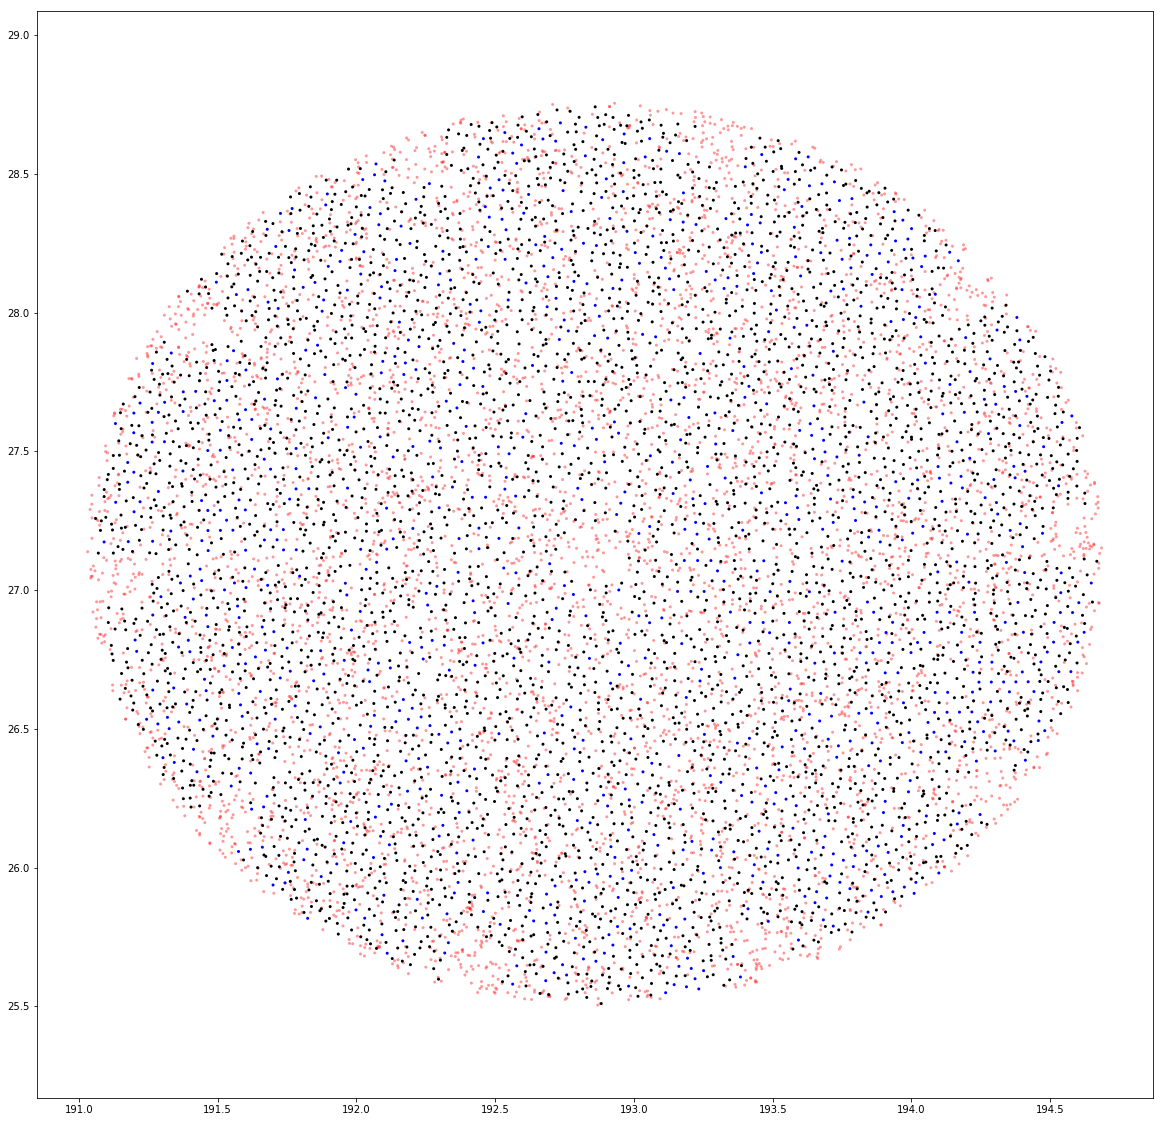

In [105]:
_unobs = mtl[is_in_this_program & ~is_observed_this_program]
_obs   = mtl[is_observed_this_program]
pl.figure(figsize=(20,20));
pl.scatter(_unobs['RA'], _unobs['DEC'],s=9,edgecolor='None',alpha=0.4,c='r');
pl.scatter(_obs['RA'], _obs['DEC'],s=9,edgecolor='None',alpha=1,c='k');
pl.scatter(no_target['TARGET_RA'], no_target['TARGET_DEC'],s=9,edgecolor='None',alpha=1,c='b');

pl.axis('equal');

In [84]:
t_obs = Table(_obs)['RA','DEC','TARGETID']
t_obs.write('mws_sv_main_ngp_obs.fits',overwrite=True)

In [83]:
t_unobs = Table(_unobs)['RA','DEC','TARGETID']
t_unobs.write('mws_sv_main_ngp_unobs.fits',overwrite=True)

In [78]:
pwd

'/global/u1/a/apcooper/projects/ssv_plan'

In [104]:
print(no_target['TARGET_RA','TARGET_DEC','TARGETID'])

  TARGET_RA     TARGET_DEC  TARGETID
------------- ------------- --------
192.814404504 26.3484712665 -5020119
192.782853737 26.3176149812 -5020132
 192.89028542 26.2611133389 -5020142
192.784847918 26.4277685333 -5020097
192.968638383 26.2832122283 -5020128
192.988863023 26.4638481019 -5020073
193.064245192 26.3759171637 -5020091
193.032380196  26.344930342 -5020103
192.816690132 26.4588271175 -5020086
193.208801594 26.0943114145 -5020177
          ...           ...      ...
193.682374264 25.8116585885 -5029493
193.592678175 25.7389492049 -5029512
193.616017593 25.8961797455 -5029432
193.736732731 26.4387354247 -5029179
193.845762297 26.3671587224 -5029225
193.730749385 26.3975374074 -5029195
193.718142461  25.789151683 -5029509
193.857974587  26.449291096 -5029192
193.888010189 26.3844405242 -5029224
 193.77925123 26.4560039155 -5029178
193.484175992 25.8061899176 -5029458
Length = 898 rows


In [98]:
for w in np.flatnonzero(is_in_this_program)[0:10]:
    print('{:16d} {:10.7f} {:10.7f}'.format(mtl['TARGETID'][w],mtl['RA'][w],mtl['DEC'][w]))

AttributeError: 'Table' object has no attribute 'ravel'

In [38]:
utargetmask, utargetmask_c = np.unique(mtl[MWS_TARGET_NAME],return_counts=True)

In [39]:
for i in range(0,len(utargetmask)):
    print('{:6d} {}'.format(utargetmask_c[i],mws_mask.names(utargetmask[i])))

  9176 []
   470 ['MWS_WD_SV']
   668 ['MWS_NEARBY_SV']
    33 ['MWS_WD_SV', 'MWS_NEARBY_SV']
778593 ['MWS_MAIN_SV', 'MWS_MAIN_SV_NORTH']
   654 ['MWS_MAIN_SV', 'MWS_WD_SV', 'MWS_MAIN_SV_NORTH']
   655 ['MWS_MAIN_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_NORTH']
   108 ['MWS_MAIN_SV', 'MWS_WD_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_NORTH']
831579 ['MWS_MAIN_SV', 'MWS_MAIN_SV_SOUTH']
   802 ['MWS_MAIN_SV', 'MWS_WD_SV', 'MWS_MAIN_SV_SOUTH']
   884 ['MWS_MAIN_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_SOUTH']
   145 ['MWS_MAIN_SV', 'MWS_WD_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_SOUTH']
457610 ['MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_NORTH']
  1318 ['MWS_WD_SV', 'MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_NORTH']
   121 ['MWS_NEARBY_SV', 'MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_NORTH']
    40 ['MWS_WD_SV', 'MWS_NEARBY_SV', 'MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_NORTH']
506289 ['MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
  1617 ['MWS_WD_SV', 'MWS_MAIN_SV_FAINT', 'MWS_MAIN_SV_FAINT_SOUTH']
   173 ['MWS_NEARBY_SV', 

In [40]:
for itile in range(0,len(tiles)):
    tileid = tiles['TILEID'][itile]
    
    if not tileid in fib.keys():
        print('Tile ID {} ({}) not in fiber tables'.format(tileid,tile_to_program[tileid]))
        continue
        
    is_mws_sv_main        = (mtl[MWS_TARGET_NAME] & mws_mask['MWS_WD_SV']) != 0
    is_observed_this_tile = (mtl_observed_tilebits & 2**itile) != 0
    is_in_this_tile       = (mtl_tilebits & 2**itile) != 0
    
    frac_observed = np.sum(is_mws_sv_main & is_observed_this_tile) / np.sum(is_mws_sv_main & is_in_this_tile)
    
    print("{:15s} {:4d} {:4.0f}%".format(tile_to_program[tileid], tileid, frac_observed*100))  

NGP             1000   96%
M53+N5053       1001   88%
M53+N5053       1002   88%
GD1-B           1003   86%
GD1-B           1004   91%
GD1-B           1005   90%
M5              1006   72%
M5              1007   72%
M13             1008   87%
M13             1009   87%
DRACO           1010   85%
DRACO           1011   85%
DRACO           1012   85%
DRACO           1013   85%
M67             1014   87%
M67             1015   87%
M92             1016   84%
M92             1017   84%
BOSS7456        1018   90%
GD1-C           1019   82%
Tile ID 1020 (HYADES) not in fiber tables
Tile ID 1021 (HYADES) not in fiber tables
Tile ID 1022 (HYADES) not in fiber tables
Tile ID 1023 (HYADES) not in fiber tables
ORPHAN-A        1024   91%
ORPHAN-A        1025   82%
ORPHAN-A        1026   97%


In [41]:
tiles

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
1000,192.859477895,27.128252415,0,1,0.0,1.0,1.0,1.0,MWSV,4
1001,199.0,18.3,0,1,0.0,1.0,1.0,1.0,MWSV,4
1002,199.0,18.3,0,1,0.0,1.0,1.0,1.0,MWSV,4
1003,150.024572128,37.3123323103,0,1,0.0,1.0,1.0,1.0,MWSV,4
1004,151.750776486,39.0385366687,0,1,0.0,1.0,1.0,1.0,MWSV,4
1005,148.298367769,35.5861279518,0,1,0.0,1.0,1.0,1.0,MWSV,4
1006,229.638416667,2.08102777778,0,1,0.0,1.0,1.0,1.0,MWSV,4
1007,229.638416667,2.08102777778,0,1,0.0,1.0,1.0,1.0,MWSV,4
1008,250.421833333,36.4598611111,0,1,0.0,1.0,1.0,1.0,MWSV,4
